In [575]:
#Loading Important libraries
import os
import pandas as pd
import numpy as np
from geopy.distance import geodesic
from sklearn.preprocessing import LabelEncoder
import re #Using regex to extract date and time
import sklearn
import reverse_geocoder as rg 
import pprint
from pygeocoder import Geocoder
from fancyimpute import KNN
import warnings
warnings.filterwarnings('ignore')
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

In [576]:
#Loading Data set
os.chdir("C:/Users/Deepanshu/Desktop/Data science/cab project/cab fare project")
cab = pd.read_csv("train_cab.csv" , engine = 'python') 
test = pd.read_csv("test.csv" , engine = 'python')

In [577]:
cab.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1.0


Here the training data contains 7 variables:
- 6 are independent variables and fare_amount is a target variable.
- pickup_datetime contains timestamp value
- All variables except passenger_count are continous variables
- The target variable is also a continuous variable so this is a regression problem

In [578]:
cab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16067 entries, 0 to 16066
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fare_amount        16043 non-null  object 
 1   pickup_datetime    16067 non-null  object 
 2   pickup_longitude   16067 non-null  float64
 3   pickup_latitude    16067 non-null  float64
 4   dropoff_longitude  16067 non-null  float64
 5   dropoff_latitude   16067 non-null  float64
 6   passenger_count    16012 non-null  float64
dtypes: float64(5), object(2)
memory usage: 878.8+ KB


In [579]:
#Converting into variable types
cab.loc[:, cab.columns != "pickup_datetime"] = cab.loc[:, cab.columns != "pickup_datetime"].apply(pd.to_numeric, errors='coerce')

In [580]:
cab.dtypes

fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      float64
dtype: object

# Exploratory data analysis

The facts that we can derive from the data are: 
1. The cab fare cannot be negative
2. The range of longitude is -180 to 180 and latitude is -90 to 90 or if all are 0 then this is error indicating equator point location causing a high km range in distance 
we will calculate distance using longitude and latitude 
3. The range of passengers can be 1 to 6
so we will keep all the values within these ranges and remove the rest of the observations 

In [581]:
for i in range(len(cab)):
    if cab["fare_amount"].loc[i] < 0:
        cab["fare_amount"].loc[i] = np.nan
    elif cab["passenger_count"].loc[i] > 6:
        cab["passenger_count"].loc[i] = np.nan
    elif cab["passenger_count"].loc[i] < 1:
        cab["passenger_count"].loc[i] = np.nan
cab = cab.fillna(0)
cab['pickup_latitude'].loc[5686] = 40.1083
zcheck = cab.loc[(cab["fare_amount"] == 0) & (cab["passenger_count"] == 0)]
zcheck1 = cab.loc[cab["passenger_count"] == 0]
zcheck2 = cab.loc[cab["fare_amount"] == 0]
print(zcheck.shape, zcheck1.shape, zcheck2.shape)

(1, 7) (133, 7) (29, 7)


- only at index 5686 the pickup latitude value is out of range that because of decimal error. so shifting one place earlier
- only 1 observation contains both 0 passenger count and 0  fare amount . (zcheck)
- We have 132 observations which show passenger count as 0 but correspondingly fare amount is > 0 so it can be due to technical fault to detect no. of passengers. so we will drop the observations (zcheck1)
- 29 observations which show fare_amount as 0 value. so it can be either by human error or some technical issue. So we can drop these observations now we will drop the observations with 0 value in fare amount and passengers count (zcheck2)

In [582]:
#dropping the unwanted observations
cname = ["fare_amount","passenger_count"]
for i in cname:
    cab = cab.drop(cab[cab.loc[:,i] == 0 ].index)

cab['passenger_count'].isnull().sum()

0

In [583]:
#function for finding the location name from coordinates
def reverseGeocode(coordinates): 
    result = rg.search(coordinates)
    return result 
#Deriving the city names of pickup location and drop off location
def cityname(df):
    pick_city =  df[['pickup_latitude', 'pickup_longitude']]
    drop_city =  df[['dropoff_latitude', 'dropoff_longitude']]
    p = [tuple(x) for x in pick_city.to_numpy()]
    d = [tuple(x) for x in drop_city.to_numpy()]
    p_name = reverseGeocode(p)
    d_name = reverseGeocode(d)
    df1 = pd.DataFrame(p_name)
    df2 = pd.DataFrame(d_name)
    df["pickup_city"] = df1['name']
    df["drop_city"] = df2['name']
#classifying the travel type in terms of intercity and intracity
def citycheck(i):
    if i['pickup_city'] == i['drop_city']:
        return 'Intracity'
    else:
        return 'Intercity'


In [584]:
cityname(cab)
cityname(test) #extracting pickup and dropoff location citynames to check inter city or intra city cab service
cab['distance_type'] = cab.apply (lambda i :citycheck(i), axis=1)
test['distance_type'] = test.apply(lambda i :citycheck(i), axis=1)
cab = cab.drop(["drop_city","pickup_city"], axis = 1)
test = test.drop(["drop_city", "pickup_city"], axis = 1)
#we dropped the variables with city names 

In [585]:
#function for calculating distance travelled in a journey
def distance_calc(i):
    start = (i['pickup_latitude'], i['pickup_longitude'])
    stop = (i['dropoff_latitude'], i['dropoff_longitude'])

    return geodesic(start, stop).km
cab['distance'] = cab.apply (lambda i :distance_calc(i), axis=1)
test['distance'] = test.apply(lambda i :distance_calc(i), axis=1)
cab = cab.drop(["pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude"], axis = 1)
test = test.drop(["pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude"], axis = 1)

now there is no need of the variables with longitude and latitude information. so we can drop them

In [586]:
cab.head()

,fare_amount,pickup_datetime,passenger_count,distance_type,distance
0,4.5,2009-06-15 17:26:21 UTC,1.0,Intracity,1.029601
1,16.9,2010-01-05 16:52:16 UTC,1.0,Intercity,8.443441
2,5.7,2011-08-18 00:35:00 UTC,2.0,Intercity,1.389132
3,7.7,2012-04-21 04:30:42 UTC,1.0,Intercity,2.795790
4,5.3,2010-03-09 07:51:00 UTC,1.0,Intracity,1.998338


In [587]:
test.head()

,pickup_datetime,passenger_count,distance_type,distance
0,2015-01-27 13:08:24 UTC,1,Intercity,2.320991
1,2015-01-27 13:08:24 UTC,1,Intracity,2.423802
2,2011-10-08 11:53:44 UTC,1,Intracity,0.618182
3,2012-12-01 21:12:12 UTC,1,Intercity,1.959671
4,2012-12-01 21:12:12 UTC,1,Intercity,5.382833


In [588]:
#function for extracting year, month, hours, day 
def datetime(cab1):
    cab1['Date']= cab1['pickup_datetime'].str.extract('(....-..-..)', expand=True)
    cab1['Time']= cab1['pickup_datetime'].str.extract('(..:..)', expand=True)
    cab1['Year']= cab1['Date'].str.extract('(....)', expand=True)
    cab1['Month']= cab1['Date'].str.extract('(-..)', expand=True)
    cab1['Hours']= cab1['Time'].str.extract('(..)', expand=True)
    cab1['Month']= cab1['Month'].str.replace('-',' ')
    cab1['Date'] = pd.to_datetime(cab1['Date'])
    cab1['Day']= cab1['Date'].dt.day_name()

In [589]:
datetime(cab)
datetime(test)

In [590]:
cab = cab.drop(['Date', 'Time', 'pickup_datetime'], axis=1)#removing the unwanted variables
test = test.drop(['Date', 'Time', 'pickup_datetime'], axis=1)

In [591]:
cab.head()

,fare_amount,passenger_count,distance_type,distance,Year,Month,Hours,Day
0,4.5,1.0,Intracity,1.029601,2009,06,17,Monday
1,16.9,1.0,Intercity,8.443441,2010,01,16,Tuesday
2,5.7,2.0,Intercity,1.389132,2011,08,00,Thursday
3,7.7,1.0,Intercity,2.795790,2012,04,04,Saturday
4,5.3,1.0,Intracity,1.998338,2010,03,07,Tuesday


In [592]:
test.head()

,passenger_count,distance_type,distance,Year,Month,Hours,Day
0,1,Intercity,2.320991,2015,01,13,Tuesday
1,1,Intracity,2.423802,2015,01,13,Tuesday
2,1,Intracity,0.618182,2011,10,11,Saturday
3,1,Intercity,1.959671,2012,12,21,Saturday
4,1,Intercity,5.382833,2012,12,21,Saturday


In [593]:
#converting Day categories into numerical form
def day(x):
    Day_cat = {"Day": {"Sunday": 7 , "Monday": 1, "Tuesday": 2, "Wednesday": 3, "Thursday": 4, "Friday": 5, "Saturday":6}}
    x.replace(Day_cat, inplace=True) 

In [594]:
day(cab)
day(test)

In [595]:
cab = cab.fillna(0)
cnames = ["Year","Month","Hours","Day"]
for i in cnames:
    cab = cab.drop(cab[cab.loc[:,i] == 0 ].index)

In [596]:
cab.head()

,fare_amount,passenger_count,distance_type,distance,Year,Month,Hours,Day
0,4.5,1.0,Intracity,1.029601,2009,06,17,1.0
1,16.9,1.0,Intercity,8.443441,2010,01,16,2.0
2,5.7,2.0,Intercity,1.389132,2011,08,00,4.0
3,7.7,1.0,Intercity,2.795790,2012,04,04,6.0
4,5.3,1.0,Intracity,1.998338,2010,03,07,2.0


In [597]:
test.head()

,passenger_count,distance_type,distance,Year,Month,Hours,Day
0,1,Intercity,2.320991,2015,01,13,2
1,1,Intracity,2.423802,2015,01,13,2
2,1,Intracity,0.618182,2011,10,11,6
3,1,Intercity,1.959671,2012,12,21,6
4,1,Intercity,5.382833,2012,12,21,6


In [598]:
#converting all 0 values into nan to crate missing values
for i in range(len(cab)):
    if cab["distance"].iloc[i] == 0:
        cab["distance"].iloc[i] = np.nan

In [599]:
cab.isnull().sum()

fare_amount          0
passenger_count      0
distance_type        0
distance           454
Year                 0
Month                0
Hours                0
Day                  0
dtype: int64

In [600]:
#454 observations of distance show 0 value. so it can be either by human error or some technical issue
miss_percentage = (454/ len(cab))*100
print(miss_percentage)

2.854448286702295


As missing value percentage is 2.85% which is less than 30. so we will not drop this variable. We will try to impute the missing values using  methods.
Any random loctaion 3424 and Actual value of distance = 1.509
- mean = 15.07
- median = 2.127
- knn = 1.878
So knn is closest. so we will apply knn method on all the missing values and fields containing 0 of distance variable 

In [601]:
#applying knn imputation
kn = cab[['distance','fare_amount', 'passenger_count']]

In [602]:
cabcopy = pd.DataFrame(KNN(k=5).fit_transform(kn))

Imputing row 1/15905 with 0 missing, elapsed time: 60.643
Imputing row 101/15905 with 0 missing, elapsed time: 60.645
Imputing row 201/15905 with 0 missing, elapsed time: 60.646
Imputing row 301/15905 with 0 missing, elapsed time: 60.648
Imputing row 401/15905 with 0 missing, elapsed time: 60.649
Imputing row 501/15905 with 0 missing, elapsed time: 60.650
Imputing row 601/15905 with 0 missing, elapsed time: 60.652
Imputing row 701/15905 with 0 missing, elapsed time: 60.653
Imputing row 801/15905 with 0 missing, elapsed time: 60.655
Imputing row 901/15905 with 0 missing, elapsed time: 60.656
Imputing row 1001/15905 with 0 missing, elapsed time: 60.658
Imputing row 1101/15905 with 0 missing, elapsed time: 60.659
Imputing row 1201/15905 with 1 missing, elapsed time: 60.661
Imputing row 1301/15905 with 0 missing, elapsed time: 60.662
Imputing row 1401/15905 with 0 missing, elapsed time: 60.664
Imputing row 1501/15905 with 0 missing, elapsed time: 60.665
Imputing row 1601/15905 with 0 missi

In [603]:
cab = pd.concat([cab.reset_index(drop = True), cabcopy[0]], axis = 1)
cab = cab.drop(['distance'], axis=1)
cab = cab.rename(columns = {0:'distance'})

In [604]:
cab.isnull().sum() 

fare_amount        0
passenger_count    0
distance_type      0
Year               0
Month              0
Hours              0
Day                0
distance           0
dtype: int64

In [605]:
cab.head()

,fare_amount,passenger_count,distance_type,Year,Month,Hours,Day,distance
0,4.5,1.0,Intracity,2009,06,17,1.0,1.029601
1,16.9,1.0,Intercity,2010,01,16,2.0,8.443441
2,5.7,2.0,Intercity,2011,08,00,4.0,1.389132
3,7.7,1.0,Intercity,2012,04,04,6.0,2.795790
4,5.3,1.0,Intracity,2010,03,07,2.0,1.998338


Outlier analysis using box plot method

(0, 30)

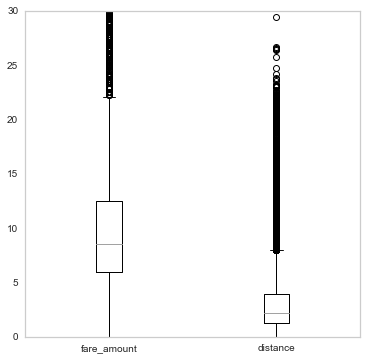

In [606]:
bp = cab.boxplot(column =["fare_amount", "distance"], figsize = (6,6), grid = False)
bp.set_ylim(0,30)

In [607]:
cab.isnull().sum() 

fare_amount        0
passenger_count    0
distance_type      0
Year               0
Month              0
Hours              0
Day                0
distance           0
dtype: int64

In [608]:
#function for finding outliers and converting them into nan
def outlier_treat(x):
    q75,q25 = np.percentile(cab[x], [75,25])
    iqr = q75 - q25
    min1 = q25 - (iqr*1.5)
    max1 = q75 + (iqr*1.5)
    cab.loc[cab[x] < min1, x] = np.nan
    cab.loc[cab[x] > max1, x] = np.nan

In [609]:
outlier_treat("distance")
outlier_treat("fare_amount")

In [610]:
cab.isnull().sum() # total of 2785 outliers detected. 
#So we will try to impute the outliers with knn method by creating missing values

fare_amount        1391
passenger_count       0
distance_type         0
Year                  0
Month                 0
Hours                 0
Day                   0
distance           1394
dtype: int64

In [611]:
out = cab[["fare_amount","distance"]]

In [612]:
#applying KNN imputation to impute the values in place of outliers
copy2 = pd.DataFrame(KNN(k=3).fit_transform(out))

Imputing row 1/15905 with 0 missing, elapsed time: 62.305
Imputing row 101/15905 with 0 missing, elapsed time: 62.307
Imputing row 201/15905 with 0 missing, elapsed time: 62.309
Imputing row 301/15905 with 0 missing, elapsed time: 62.311
Imputing row 401/15905 with 1 missing, elapsed time: 62.312
Imputing row 501/15905 with 0 missing, elapsed time: 62.314
Imputing row 601/15905 with 0 missing, elapsed time: 62.317
Imputing row 701/15905 with 0 missing, elapsed time: 62.319
Imputing row 801/15905 with 0 missing, elapsed time: 62.321
Imputing row 901/15905 with 1 missing, elapsed time: 62.322
Imputing row 1001/15905 with 0 missing, elapsed time: 62.325
Imputing row 1101/15905 with 2 missing, elapsed time: 62.327
Imputing row 1201/15905 with 0 missing, elapsed time: 62.328
Imputing row 1301/15905 with 1 missing, elapsed time: 62.330
Imputing row 1401/15905 with 0 missing, elapsed time: 62.332
Imputing row 1501/15905 with 0 missing, elapsed time: 62.335
Imputing row 1601/15905 with 0 missi

In [613]:
cab = pd.concat([cab.reset_index(drop = True), copy2], axis = 1)
cab['fare_amount'] = copy2[0]
cab['distance'] = copy2[1]

In [614]:
cab = cab.drop([0,1], axis = 1)

In [615]:
cab.head()

,fare_amount,passenger_count,distance_type,Year,Month,Hours,Day,distance
0,4.5,1.0,Intracity,2009,06,17,1.0,1.029601
1,16.9,1.0,Intercity,2010,01,16,2.0,5.903157
2,5.7,2.0,Intercity,2011,08,00,4.0,1.389132
3,7.7,1.0,Intercity,2012,04,04,6.0,2.795790
4,5.3,1.0,Intracity,2010,03,07,2.0,1.998338


In [616]:
cname = ["fare_amount","distance"]
for i in cname:
    cab = cab.drop(cab[cab.loc[:,i] == 0 ].index)

In [617]:
cab.shape

(14783, 8)

After pre processing we eliminated total 1284 observations 

(-10, 30)

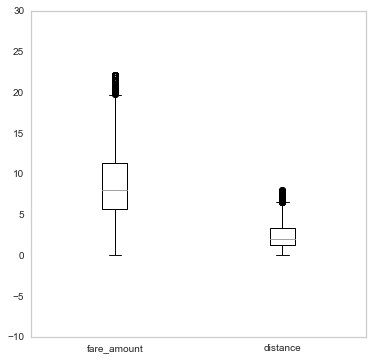

In [618]:
bp = cab.boxplot(column =["fare_amount", "distance"], figsize = (6,6), grid = False)
bp.set_ylim(-10,30) 
#now the datapoints are in acceptable range. So we can move further with this data

Counting unique values in each categorical variable

In [619]:
cab["passenger_count"] = cab["passenger_count"].astype('int').round().astype('object').astype('category')
test["passenger_count"] = test["passenger_count"].astype('int').round().astype('object').astype('category')

In [620]:
cat = ["Day", "Year", "Month", "Hours", "passenger_count"]

In [621]:
for i in cat:
    print(i)
    print(cab[i].value_counts())
    print("###############################")

Day
6.0    2283
5.0    2198
3.0    2159
4.0    2147
2.0    2113
7.0    1958
1.0    1925
Name: Day, dtype: int64
###############################
Year
2012    2353
2010    2350
2013    2316
2009    2312
2011    2305
2014    2104
2015    1043
Name: Year, dtype: int64
###############################
Month
 03    1410
 05    1391
 01    1381
 06    1372
 04    1318
 02    1231
 10    1159
 12    1150
 11    1123
 09    1116
 07    1107
 08    1025
Name: Month, dtype: int64
###############################
Hours
19    940
18    924
20    912
21    862
22    841
09    743
12    738
17    726
13    716
23    716
14    712
15    677
11    675
08    665
10    623
07    585
16    577
00    557
01    416
02    305
06    293
03    270
04    175
05    135
Name: Hours, dtype: int64
###############################
passenger_count
1    10488
2     2116
5      964
3      625
4      307
6      283
Name: passenger_count, dtype: int64
###############################


Converting into categories 

In [622]:
def g(x):
    if (x >=1) and (x <= 6):
        return "1st_half"
    elif (x >=7) and (x <= 12 ):
        return "2nd_half"

def h(x):
    if (x >=1) and (x <= 5):
        return "weekday"
    elif (x >=6) and (x <=7):
        return "weekend"
    
def i(x):
    if (x >=0) and (x <= 7):
        return "morning"
    elif (x >= 8) and (x <= 17):
        return "day"
    elif (x >= 18) and (x <= 23):
        return "evening"
    
def c(x):
    if x <= 4:
        return 'Hatchback'
    else:
        return "SUV"

In [623]:
test[['Year', 'Month', 'Hours']] = test[['Year', 'Month', 'Hours']].apply(pd.to_numeric, errors = 'coerce')
cab[['Year', 'Month', 'Hours']] = cab[['Year', 'Month', 'Hours']].apply(pd.to_numeric, errors = 'coerce')

In [624]:
cab["Month"] = cab['Month'].apply(g)
cab["Day"] = cab['Day'].apply(h)
cab["Hours"] = cab['Hours'].apply(i)
cab["Car_type"] = cab['passenger_count'].apply(c)
test["Month"] = test['Month'].apply(g)
test["Day"] = test['Day'].apply(h)
test["Hours"] = test['Hours'].apply(i)
test["Car_type"] = test['passenger_count'].apply(c)

In [625]:
test.head()

,passenger_count,distance_type,distance,Year,Month,Hours,Day,Car_type
0,1,Intercity,2.320991,2015,1st_half,day,weekday,Hatchback
1,1,Intracity,2.423802,2015,1st_half,day,weekday,Hatchback
2,1,Intracity,0.618182,2011,2nd_half,day,weekend,Hatchback
3,1,Intercity,1.959671,2012,2nd_half,evening,weekend,Hatchback
4,1,Intercity,5.382833,2012,2nd_half,evening,weekend,Hatchback


In [626]:
cab.head()

,fare_amount,passenger_count,distance_type,Year,Month,Hours,Day,distance,Car_type
0,4.5,1,Intracity,2009,1st_half,day,weekday,1.029601,Hatchback
1,16.9,1,Intercity,2010,1st_half,day,weekday,5.903157,Hatchback
2,5.7,2,Intercity,2011,2nd_half,morning,weekday,1.389132,Hatchback
3,7.7,1,Intercity,2012,1st_half,morning,weekend,2.795790,Hatchback
4,5.3,1,Intracity,2010,1st_half,morning,weekday,1.998338,Hatchback


In [627]:
cabdu = cab.copy()
testdu = test.copy()

In [628]:
cabdu["passenger_count"] = cabdu["passenger_count"].astype('int').round().astype('object').astype('category')
testdu["passenger_count"] = testdu["passenger_count"].astype('int').round().astype('object').astype('category')

Creating dummies of the categorical variables

In [629]:
temp = pd.get_dummies(cabdu['passenger_count'], prefix = 'passenger_count')
cabdu = cabdu.join(temp)
temp = pd.get_dummies(cabdu['Year'], prefix = 'Year')
cabdu = cabdu.join(temp)
temp = pd.get_dummies(cabdu['Month'], prefix = 'Month')
cabdu = cabdu.join(temp)
temp = pd.get_dummies(cabdu['Hours'], prefix = 'Hours')
cabdu = cabdu.join(temp)
temp = pd.get_dummies(cabdu['Day'], prefix = 'Day')
cabdu = cabdu.join(temp)
temp = pd.get_dummies(cabdu['Car_type'], prefix = 'Car_type')
cabdu = cabdu.join(temp)
temp = pd.get_dummies(cabdu['distance_type'], prefix = 'distance_type')
cabdu = cabdu.join(temp)

temp = pd.get_dummies(testdu['passenger_count'], prefix = 'passenger_count')
testdu = testdu.join(temp)
temp = pd.get_dummies(testdu['Year'], prefix = 'Year')
testdu = testdu.join(temp)
temp = pd.get_dummies(testdu['Month'], prefix = 'Month')
testdu = testdu.join(temp)
temp = pd.get_dummies(testdu['Hours'], prefix = 'Hours')
testdu = testdu.join(temp)
temp = pd.get_dummies(testdu['Day'], prefix = 'Day')
testdu = testdu.join(temp)
temp = pd.get_dummies(testdu['Car_type'], prefix = 'Car_type')
testdu = testdu.join(temp)
temp = pd.get_dummies(testdu['distance_type'], prefix = 'distance_type')
testdu = testdu.join(temp)

In [630]:
cabdu.columns

Index(['fare_amount', 'passenger_count', 'distance_type', 'Year', 'Month',
       'Hours', 'Day', 'distance', 'Car_type', 'passenger_count_1',
       'passenger_count_2', 'passenger_count_3', 'passenger_count_4',
       'passenger_count_5', 'passenger_count_6', 'Year_2009', 'Year_2010',
       'Year_2011', 'Year_2012', 'Year_2013', 'Year_2014', 'Year_2015',
       'Month_1st_half', 'Month_2nd_half', 'Hours_day', 'Hours_evening',
       'Hours_morning', 'Day_weekday', 'Day_weekend', 'Car_type_Hatchback',
       'Car_type_SUV', 'distance_type_Intercity', 'distance_type_Intracity'],
      dtype='object')

we will drop one column from each one-hot-encoded variables

In [631]:
cabdu.head()

,fare_amount,passenger_count,distance_type,Year,Month,Hours,Day,distance,Car_type,passenger_count_1,...,Month_2nd_half,Hours_day,Hours_evening,Hours_morning,Day_weekday,Day_weekend,Car_type_Hatchback,Car_type_SUV,distance_type_Intercity,distance_type_Intracity
0,4.5,1,Intracity,2009,1st_half,day,weekday,1.029601,Hatchback,1,...,0,1,0,0,1,0,1,0,0,1
1,16.9,1,Intercity,2010,1st_half,day,weekday,5.903157,Hatchback,1,...,0,1,0,0,1,0,1,0,1,0
2,5.7,2,Intercity,2011,2nd_half,morning,weekday,1.389132,Hatchback,0,...,1,0,0,1,1,0,1,0,1,0
3,7.7,1,Intercity,2012,1st_half,morning,weekend,2.795790,Hatchback,1,...,0,0,0,1,0,1,1,0,1,0
4,5.3,1,Intracity,2010,1st_half,morning,weekday,1.998338,Hatchback,1,...,0,0,0,1,1,0,1,0,0,1


In [632]:
cabdu =cabdu.drop(['passenger_count', 'distance_type', 'Year', 'Month','Hours', 'Day',  'Car_type', 'passenger_count_5', 'Year_2015','Month_1st_half','Hours_morning', 'Day_weekend', 'Car_type_SUV', 'distance_type_Intracity'],axis=1)
testdu =testdu.drop(['passenger_count', 'distance_type', 'Year', 'Month','Hours', 'Day',  'Car_type', 'passenger_count_5', 'Year_2015','Month_1st_half','Hours_morning', 'Day_weekend', 'Car_type_SUV', 'distance_type_Intracity'],axis=1)


In [633]:
cabdu.columns

Index(['fare_amount', 'distance', 'passenger_count_1', 'passenger_count_2',
       'passenger_count_3', 'passenger_count_4', 'passenger_count_6',
       'Year_2009', 'Year_2010', 'Year_2011', 'Year_2012', 'Year_2013',
       'Year_2014', 'Month_2nd_half', 'Hours_day', 'Hours_evening',
       'Day_weekday', 'Car_type_Hatchback', 'distance_type_Intercity'],
      dtype='object')

In [634]:
testdu.columns

Index(['distance', 'passenger_count_1', 'passenger_count_2',
       'passenger_count_3', 'passenger_count_4', 'passenger_count_6',
       'Year_2009', 'Year_2010', 'Year_2011', 'Year_2012', 'Year_2013',
       'Year_2014', 'Month_2nd_half', 'Hours_day', 'Hours_evening',
       'Day_weekday', 'Car_type_Hatchback', 'distance_type_Intercity'],
      dtype='object')

In [635]:
cabdu.head()

,fare_amount,distance,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_6,Year_2009,Year_2010,Year_2011,Year_2012,Year_2013,Year_2014,Month_2nd_half,Hours_day,Hours_evening,Day_weekday,Car_type_Hatchback,distance_type_Intercity
0,4.5,1.029601,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0
1,16.9,5.903157,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,1
2,5.7,1.389132,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,1,1
3,7.7,2.795790,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1
4,5.3,1.998338,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0


Correlation analysis

In [636]:
colnames = ["fare_amount", "distance"]
df_corr = cabdu.loc[:, colnames]

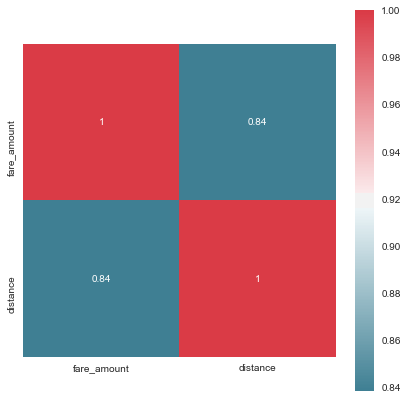

In [637]:
f, ax = plt.subplots(figsize = (7 , 7))
corr1 = df_corr.corr()
sns.heatmap(corr1, cmap = sns.diverging_palette(220,10,as_cmap = True), square = True,annot=True)
# so here we see that there is no correlation between two independent variables .
#and there is high correlation between indepedent and dependent variable that is distance and fare_amount 
#which both are continuous variable and rest are categorical variables.

Annova Test

In [638]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

In [639]:
model = ols('fare_amount ~ C(passenger_count_1)+ C(passenger_count_2) + C(passenger_count_3) +C(passenger_count_4) + C(passenger_count_6) +C(Year_2009) + C(Year_2010) + C(Year_2011) + C(Year_2012)+ C(Year_2013) + C(Year_2014)+ C(Month_2nd_half)+ C(Hours_day) +C(Hours_evening) + C(Day_weekday) + C(Car_type_Hatchback) + C(distance_type_Intercity)', data=cabdu).fit()
aov_table = sm.stats.anova_lm(model)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
C(passenger_count_1),1.0,76.425225,76.425225,4.440972,3.510308e-02
C(passenger_count_2),1.0,0.437016,0.437016,0.025394,8.733902e-01
C(passenger_count_3),1.0,3.837124,3.837124,0.222970,6.367929e-01
C(passenger_count_4),1.0,67.925290,67.925290,3.947052,4.697201e-02
C(passenger_count_6),1.0,260.721853,260.721853,15.150214,9.972342e-05
C(Year_2009),1.0,1175.577864,1175.577864,68.311328,1.514047e-16
C(Year_2010),1.0,1913.500915,1913.500915,111.191094,6.642328e-26
C(Year_2011),1.0,1994.607208,1994.607208,115.904077,6.279505e-27
C(Year_2012),1.0,1345.718534,1345.718534,78.197985,1.036153e-18
C(Year_2013),1.0,48.453889,48.453889,2.815594,9.337352e-02


Hypothesis testing :

- Null Hypothesis: mean of all categories in a variable are same.
- Alternate Hypothesis: mean of at least one category in a variable is different.
- If p-value is less than 0.05 then we reject the null hypothesis.
- And if p-value is greater than 0.05 then we accept the null hypothesis.

Here all p values are less than 0.05 , so we reject null hypothesis

In [640]:
cabdu.head()

,fare_amount,distance,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_6,Year_2009,Year_2010,Year_2011,Year_2012,Year_2013,Year_2014,Month_2nd_half,Hours_day,Hours_evening,Day_weekday,Car_type_Hatchback,distance_type_Intercity
0,4.5,1.029601,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0
1,16.9,5.903157,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,1
2,5.7,1.389132,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,1,1
3,7.7,2.795790,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1
4,5.3,1.998338,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0


In [641]:
testdu.head()

,distance,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_6,Year_2009,Year_2010,Year_2011,Year_2012,Year_2013,Year_2014,Month_2nd_half,Hours_day,Hours_evening,Day_weekday,Car_type_Hatchback,distance_type_Intercity
0,2.320991,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1
1,2.423802,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0
2,0.618182,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0
3,1.959671,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,1
4,5.382833,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,1


Scaling of variables

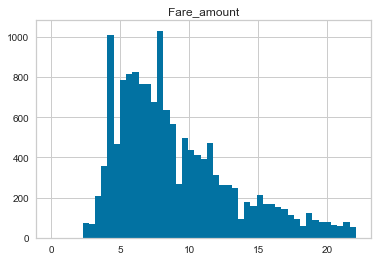

In [642]:
hist1 = plt.hist(cabdu["fare_amount"], bins = 'auto') #normally distrubted, so no need of any feature scaling technique.
plt.title("Fare_amount")
plt.savefig("scaling 1")

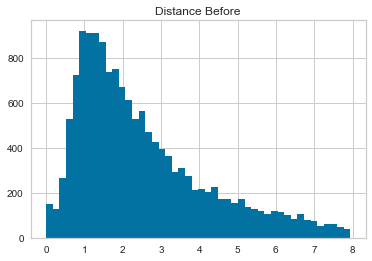

In [643]:
hist = plt.hist(cabdu["distance"], bins = 'auto')
plt.title("Distance Before")
plt.savefig("scaling 2")

In [644]:
cabdu['distance'].var()

2.9071037683327248

Applying normalization on the distance feature

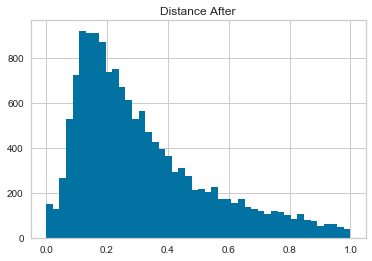

In [645]:
cabdu['distance'] = (cabdu['distance'] - min(cabdu['distance']))/(max(cabdu['distance']) - min(cabdu['distance']))
testdu['distance'] = (testdu['distance'] - min(testdu['distance']))/(max(testdu['distance']) - min(testdu['distance']))
hist = plt.hist(cabdu["distance"], bins = 'auto')
plt.title("Distance After")
plt.savefig("scaling 3")

In [646]:
cabdu.shape

(14783, 19)

In [647]:
cabdu.head()

,fare_amount,distance,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_6,Year_2009,Year_2010,Year_2011,Year_2012,Year_2013,Year_2014,Month_2nd_half,Hours_day,Hours_evening,Day_weekday,Car_type_Hatchback,distance_type_Intercity
0,4.5,0.129579,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0
1,16.9,0.742999,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,1
2,5.7,0.174832,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,1,1
3,7.7,0.351884,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1
4,5.3,0.251511,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0


In [648]:
testdu.head()

,distance,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_6,Year_2009,Year_2010,Year_2011,Year_2012,Year_2013,Year_2014,Month_2nd_half,Hours_day,Hours_evening,Day_weekday,Car_type_Hatchback,distance_type_Intercity
0,0.023195,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1
1,0.024223,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0
2,0.006178,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0
3,0.019584,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,1
4,0.053794,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,1


In [649]:
cabdu['distance'].var()

0.04605580020917598

- Before normalization the variance of distance variable was 2.90 and after normalization it is showing 0.046 which is acceptable.
- It is now showing as normally distributed after normalization on distance variable.
- now there is no need of standardization.

In [650]:
cabdu.head()

,fare_amount,distance,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_6,Year_2009,Year_2010,Year_2011,Year_2012,Year_2013,Year_2014,Month_2nd_half,Hours_day,Hours_evening,Day_weekday,Car_type_Hatchback,distance_type_Intercity
0,4.5,0.129579,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0
1,16.9,0.742999,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,1
2,5.7,0.174832,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,1,1
3,7.7,0.351884,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1
4,5.3,0.251511,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0


In [651]:
testdu.head()

,distance,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_6,Year_2009,Year_2010,Year_2011,Year_2012,Year_2013,Year_2014,Month_2nd_half,Hours_day,Hours_evening,Day_weekday,Car_type_Hatchback,distance_type_Intercity
0,0.023195,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1
1,0.024223,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0
2,0.006178,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0
3,0.019584,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,1
4,0.053794,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,1


In [653]:
cabdu.shape

(14783, 19)

In [652]:
testdu.to_csv("testpred.csv")